<a href="https://colab.research.google.com/github/uervitonsantos/Otimizacao-Politicaca-Manutencao-Preventiva-Imperfeita/blob/main/Algoritmo_PSO_para_otimiza%C3%A7%C3%A3o_de_custo_de_manuten%C3%A7%C3%A3o_preventiva_v11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Os Dataset's de dados de confiabilidade para os 4 cenarios podem ser obtidos em: https://drive.google.com/drive/folders/1tzW3424gsRYhvXOCIaF67PCb3PAiOU43?usp=drive_link

In [1]:
%%capture
pip install pyswarms

In [3]:
%%capture
!pip install numpy==1.26

In [4]:
import numpy as np
import pandas as pd
import math
import csv
import matplotlib.pyplot as plt
import time
from pyswarms.single.global_best import GlobalBestPSO
import pyswarms as ps
from pyswarms.utils.search import RandomSearch
from pyswarms.utils.functions import single_obj as fx
from pyswarms.utils.plotters import (plot_cost_history, plot_contour, plot_surface)
import plotly.graph_objects as go
from pyswarms.utils.plotters.formatters import Designer
from pyswarms.utils.plotters.formatters import Mesher
from mpl_toolkits.mplot3d import Axes3D

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
# Constantes criadas para representar alguns valores de teste no codigo

MAX_VALUE_CUSTO = 10000 # Valor maximo para o custo total da otimização
fator_melhoria = 'expo' # Função exponencial selecionada. Há outras funções desenvolvidas
DIAS_OBSERVADOS = 600 # Quantidade de dias observados no horizonte de planejamento. Para cada teste há uma quantidade de dia específico
CMC = 4000 # Valor para o custo da manutenção corretiva
CMP = 2000 # Valor para o custo da manutenção preventiva

In [9]:
class IntensidadeFalha:
    # Este método vai inicializar cada objeto criado a partir desta classe
    # O nome deste método é "inicio"
    # (self) é uma referência a cada atributo de um objeto criado a partir desta classe
    # Os atributos de cada objeto criados a partir desta classe.
    # O self indica que estes são atributos dos objetos
    def __init__(self):
        self.fator = None
        self.lamb = None
        self.beta = None
        self.theta = None
        self.sz = None
        self.T = None
        self.u = None

    def inicio(self, T, fator, solucao):
        self.fator = fator
        self.lamb = solucao[0]
        self.beta = solucao[1]
        self.theta = solucao[2]
        self.sz = int(T[-1])
        self.T = T

    def create(self):
        self.u = []
        # Reducao de Idade com fator de melhoria linear
        for i, tc in enumerate(self.T[1:], start=1):
            for tt in range(int(self.T[i-1]), int(tc)+1):
                b = tt - self.fator[0][i-1] * self.T[i-1]
                self.u.append((1 / (self.lamb ** self.beta)) * self.beta * b ** (self.beta - 1))

                if tt == tc:
                    self.u.append(float('nan'))
            break
    # plota e salva a figura da função de intensidade de falha
    def plotar(self):
        fig = plt.figure(figsize=(20, 5))
        plt.plot(self.u)

        for xc in self.T:
            plt.axvline(x=xc, color='r', linestyle='--')

        plt.xlabel("Tempo (dias)")
        plt.ylabel("Função intensidade de falha")
        plt.xlim(0)
        plt.grid(True)
        plt.show()

In [10]:
# Define a função de melhoria constante
def const(ck, m, s, theta):
    fator = [[theta] * ck] * m
    return fator

In [11]:
# Define a função de melhoria linear
def linear(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = [0]
        for j in range(0, ck, 1):
            linha.append(s[k][j] * theta)
        fator.append(linha)
    return fator

In [12]:
# Define a função de melhoria exponencial
def expo(ck, m, s, theta):
    fator = []
    for k in range(0, m):
        linha = []
        # Verifique se o índice k é válido
        if k >= len(s):
            break
        for j in range(0, ck):
            # Verifique se o índice j é válido
            if j >= len(s[k]):
                break
            linha.append(1.0 - np.exp(-s[k][j] * theta))
        fator.append(linha)

    return fator

In [13]:
# Define a função de melhoria potência
def pot(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(s[k][j] ** theta)
        fator.append(linha)
    return fator

In [14]:
# Define a função de melhoria para manutenção perfeita
def mpp(ck, m, s, theta):
    fator = []
    for k in range(0, m, 1):
        linha = []
        for j in range(0, ck, 1):
            linha.append(1)
        fator.append(linha)
    return fator

In [15]:
# Executa a função de melhoria com base no parâmetro fornecido
def execute_function(fator_melhoria, ck, m, s, theta):
    return {
        'const': lambda: const(ck, m, s, theta),
        'linear': lambda: linear(ck, m, s, theta),
        'expo': lambda: expo(ck, m, s, theta),
        'pot': lambda: pot(ck, m, s, theta),
        'mpp': lambda: mpp(ck, m, s, theta),
    }[fator_melhoria]()

In [16]:
# Função custo de manutenção baseada em severidade
def custo_mp(s, CMP):
    dist = {0.25: 2000, 0.5: 4000, 0.75: 12000, 1.0: 20000}
    if not isinstance(s, list):
        s = [s]  # Transforma s em uma lista com um único elemento
    cmp_f = np.sum([CMP if si < 0.25 or si > 1.0 else np.interp(si, [0.25, 0.5, 0.75, 1.0], [2000, 4000, 12000, 20000]) for si in s])
    return cmp_f

O 1.º cenário, considera o dataset fictício do trabalho do Dr Marco Coque Jr, com 5 sistema, observados por 600 dias, com MP realizada nos tempos 150, 250, 500 e 600, com custo de MP apresentado na tabela 1, com taxas de severidades de 40%, 50%, 90% e 20%, respectivamente  e MC fixa em "?"

O 2.º cenário, considera o dataset fictício, com 3 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 20%, 70% e 100%, respectivamente e MC fixa em US$15.000

O 3.º cenário, considera o dataset fictício, com 2 sistemas, observados por 1.460 dias, com MP realizada nos tempos "?", com custo de MP fixo em US$4.000, com taxas de severidade fixas em 100% e MC fixa em US$17.000

O 4.º cenário, considera o dataset fictício, com 4 sistemas, observados por 730 dias, com MP realizada nos tempos "?", com custo de MP apresentado na tabela 2, com taxas de severidade fixas em 50% e 100%, onde US$2.000 e US$3.000, respectivamente e MC fixa em US$15.000 texto em itálico





In [19]:
# Defina o dicionário de tipos de dados
# define as 3 colunas do dataset como int
dtypes = {
    't': int,
    'k': int,
    'c': int,
}

# Leitura dos dados de tempo de falha para 4 cenarios de exemplo
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario02.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario03.csv.csv', sep=";")
# df = pd.read_csv('/content/drive/MyDrive/datasets/cenario04.csv.csv', sep=";")
df = pd.read_csv('/content/drive/MyDrive/datasets/cenario01.csv', sep=";")

# Remova as linhas com valores ausentes
df = df.fillna(0)

# Converta as colunas para os tipos de dados desejados
df = df.astype(dtypes)

df.head()

,t,k,c,n,s,T
0,90,1,1,4.0,0.4,150.0
1,110,1,1,0.0,0.5,250.0
2,125,1,1,9.0,0.9,500.0
3,135,1,1,2.0,0.2,600.0
4,295,1,3,2.0,0.4,0.0




*   t: Representa os tempos de falha.
*   k: Indica o índice do sistema.
*   c: Representa o número de ciclos de manutenção.
*   n: Indica o número de falhas em cada ciclo de manutenção preventiva.
*   s: Representa a severidade das manutenções preventivas em cada sistema.
*   T: Indica os tempos das manutenções preventivas.



In [20]:
# Cria as variaveis
# tempos de falhas
t = df['t']
# indice do sistema
k = df['k']
m = k.drop_duplicates().shape[0]
# Numero de ciclos de manutenção
ck = df['c'].max()
# Numero de falhas e severidade das manutenções preventivas em cada sistema
n = []
s = []
for k in range(m):
    n.append(list(df['n'][k * ck:(k + 1) * ck]))
    s.append(list(df['s'][k * ck:(k + 1) * ck]))

# Tempos das MP
T = list(df['T'][:m])

In [21]:
# Define a função objetivo para ótimização dos parametros lambda, beta, theta
def objective(x):
    #
    # Solucao a ser avaliada x = [x1, x2, x3] = [lambda, beta, theta]
    lamb = x[:, 0]
    beta = x[:, 1]
    theta = x[:, 2]

    # Cria fator de melhoria
	# variável fator_melhoria definida como 'expo' no início do programa!
    fator = execute_function(fator_melhoria, ck, m, s, theta)

    cont = 0
    fitness = 1

    for k in range(0, m, 1):
        prod = 1
        for j in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            nkj = int(n[k][j])
            for i in range(0, nkj, 1):
                prod = prod * (1/(lamb**beta)) * beta * (int(t[cont])-fator[k][j]*T[j])**(beta-1);
                cont = cont + 1;

        soma = 0
        for l in range(0, len(ck) if isinstance(ck, np.ndarray) else 1, 1):
            soma = soma + ((1/(lamb**beta))*(T[l+1]-fator[k][l]*T[l])**beta - (1/(lamb**beta))*(T[l]-fator[k][l]*T[l])**beta);

        ans = np.exp(-soma)
        fitness = fitness * prod * ans;

    return -fitness

In [22]:
# Parâmetros do PSO
num_particles = 50
max_iterations = 100
dimensions = 3
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}  # Opções do PSO

# Limites inferiores e superiores para lamb, beta e theta
lb = np.array([100, 1, 0])
ub = np.array([150, 2, 1])
bounds = (lb, ub)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Define o enxame de partículas
swarm = optimizer.swarm

# Inicializar current_cost e pbest_cost com valores infinitos
swarm.current_cost = np.full(swarm.position.shape[0], np.inf)
swarm.pbest_cost = np.full(swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective, iters=max_iterations)

# Calcula mask_cost
mask_cost = swarm.current_cost < swarm.pbest_cost

# Atualiza pbest
swarm.pbest_cost = np.where(mask_cost, swarm.current_cost, swarm.pbest_cost)
swarm.pbest_pos = np.where(mask_cost[:, np.newaxis], swarm.position, swarm.pbest_pos)

print("")
print("Melhores valores para λ, β, θ :", best_position)

2023-10-03 15:31:21,579 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=-2.16e-24
2023-10-03 15:31:22,080 - pyswarms.single.global_best - INFO - Optimization finished | best cost: -2.163735738596033e-24, best pos: [122.54713789   1.99876902   0.26467241]



Melhores valores para λ, β, θ : [122.54713789   1.99876902   0.26467241]


In [24]:
# Criação de variáveis para os parâmetros
lamb, beta, theta = best_position
print('lamb:', lamb)
print('beta:', beta)
print('theta:', theta)

lamb: 122.54713788723937
beta: 1.9987690240650657
theta: 0.264672406222762


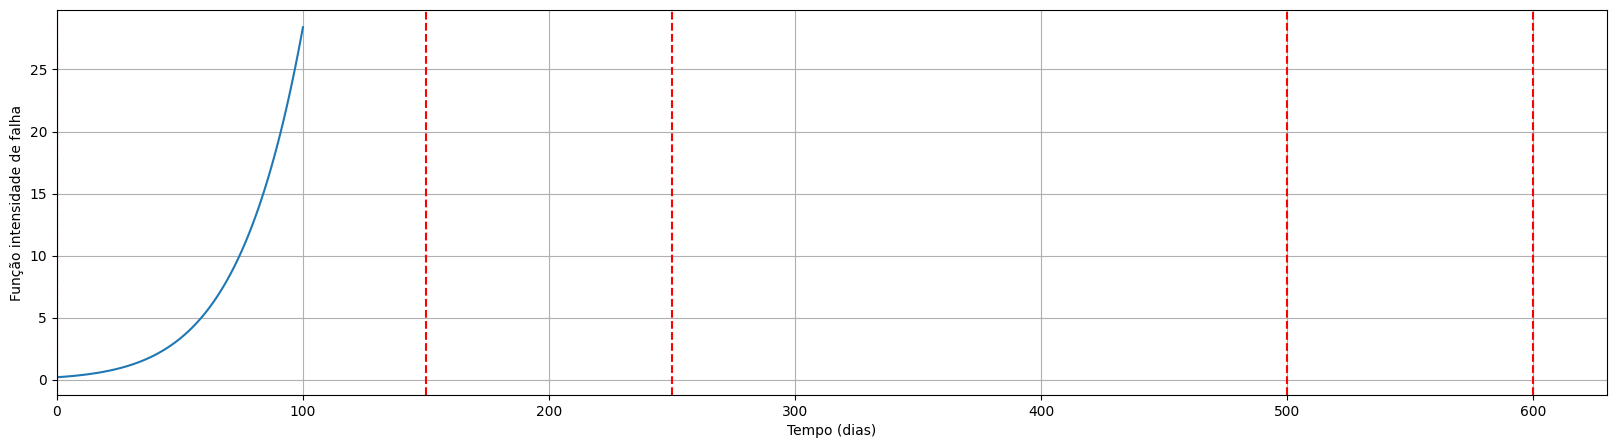

Fator ajuste:  [0.1004574858346835, 0.12395358396783229, 0.21195900439690896, 0.05155784880398928]


In [25]:
beta = beta*5
solucao = [lamb, beta, theta]

# Cria a instância da classe IntensidadeFalha
intensidadeFalha = IntensidadeFalha()

# Inicializa a instância com os valores necessários
falha = intensidadeFalha.inicio(T, execute_function(fator_melhoria, ck, m, s, theta), solucao)

# Cria os dados da intensidade de falha
intensidadeFalha.create()

# Plota o gráfico da intensidade de falha
intensidadeFalha.plotar()

fator = execute_function(fator_melhoria, ck, m, s, theta)
print('Fator ajuste: ', fator[0])

last_value_fator_ajuste = fator[0][-1]

time_duration = 1
time.sleep(time_duration)

In [26]:
# Função objetivo para otimização da politica de manutenção
# Numero de ciclos determinado pela solução
# Solução com 24 valores reais
# Solucao a ser avaliada X = [x1, ..., x24]
def objective_st(x):

    # Dicionario para severidades
    dict_severidades = {1: 0.25, 3: 0.50, 5: 0.75, 7: 1.0}

    results = [] # Lista para armazenar os resultados das funções objetivo


    # No PSO, como cada particula é um vetor de dimenções definidas, é
    # Necessario interar sobre o vetor de particulas
    for particle in x:
        T = [0]
        s_row = []
        cont = 0

        for number in particle:
            modulo = int(number) % 2
            if modulo == 1:
                inteiro = int(number)
                s_row.append(dict_severidades[inteiro])  # Severidade
                frac = number - inteiro  # Tempo
                t = (cont + frac) * 30
                T.append(int(t))
            cont += 1

    s = []
    for row in range(m):
        s.append(s_row)

    # A partir da solução define o número de ciclos
    # A variável m é o número de sistemas em análise: em nosso exemplo m = 4
    # Para novos dados esse parâmetro deve ser ajustado
    # m = 4
    ck = len(T) - 1

    print("")
    print("=========================================================================")
    print("")
    print('Número de ciclos de manutenção:', ck, m)
    print('Tempos para manutenções preventivas:', T)
    print('Severidade para cada subsistema:', s[0])
    print("Número de Sisemas:", m)

    if ck == 0:
        return MAX_VALUE_CUSTO

    # O modelo já está ajustado
    # Utilizado para avaliar a solução candidata

    # Cria fator de meloria a partir da solução
    fact = execute_function(fator_melhoria, ck, m, s, theta)
    fator = [last_value_fator_ajuste] + list(fact[0])

    print('Fator: ', fator)

    # Numero esperado de falhas (NEF) em cada ciclo
    termos_somatorio = [((1/(lamb**beta)) * (T[1]**beta))]
    numero_medio_falhas = [0, ((1/(lamb**beta)) * (T[1]**beta))]

    for i in range(ck-1):
        termo = (((T[i+2]-fator[i]*T[i+1])**beta) - (((1-fator[i])*T[i+1])**beta)) * (1/(lamb**beta))
        termos_somatorio.append(termo)
        numero_medio_falhas.append(sum(termos_somatorio))

    # Número médio de falhas até o final do período: 2 anos
    final = DIAS_OBSERVADOS
    termo = (((final-fator[ck-1]*T[ck])**beta) - (((1-fator[ck-1])*T[ck])**beta)) * (1/(lamb**beta))
    termos_somatorio.append(termo)
    numero_medio_falhas.append(sum(termos_somatorio))

    mi = numero_medio_falhas

    print('Media de falhas: ', mi)

    Ctotal =  []

    for i in range(ck):
        cmp = custo_mp(s[0][i], CMP)
        Ctotal.append((cmp + (mi[i+1] - mi[i])*CMC)/(T[i+1]-T[i]))

    cmp = custo_mp(s[0][ck-1], CMP)
    Ctotal.append((cmp + (mi[ck+1] - mi[ck])*CMC)/(final-T[ck]))

    # Custo Total
    Custo = np.sum(Ctotal)
    results.append(Custo) # Adicione o valor da função objetivo à lista de resultados
    print('Custo = ', Custo)

    # Retorne os resultados da função objetivo como um array
    return np.array(results)

In [27]:
num_particles = 100
max_iterations = 100
dimensions = 24
options = {'c1': 0.5, 'c2': 0.3, 'w': 0.9}

max_bound = np.array([7.0] * dimensions)  # Limite superior dos valores em x
min_bound = np.array([0.0] * dimensions)   # Limite inferior dos valores em x
bounds = (min_bound, max_bound)

optimizer = GlobalBestPSO(n_particles=num_particles, dimensions=dimensions, options=options, bounds=bounds)

# Inicializar current_cost e pbest_cost com valores infinitos
optimizer.swarm.current_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
optimizer.swarm.pbest_cost = np.full(optimizer.swarm.position.shape[0], np.inf)
best_cost, best_position = optimizer.optimize(objective_st, iters=max_iterations)

pbest_cost = optimizer.swarm.pbest_cost

best_positions = []  # Lista para armazenar todas as melhores posições

# Loop de iterações do PSO
for i in range(max_iterations):
    best_cost, best_position = optimizer.optimize(objective_st, iters=1)
    pbest_cost = optimizer.swarm.pbest_cost
    best_positions.append(best_position)

# Converter a lista de melhores posições em um array numpy para facilitar a manipulação
best_positions = np.array(best_positions)

2023-10-03 15:32:26,178 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   6%|▌         |6/100, best_cost=1.58e+8



Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 8, 48, 161, 214, 240, 287, 413, 446, 510, 556, 651, 673, 711]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 1.4294303132513343e-12, 7.84204005720838e-05, 10.497015226750067, 163.05442086229104, 270.7083642347732, 1123.6917648021767, 76063.65696484645, 198806.41143618154, 421964.81977207575, 1106359.9360446204, 5920233.823574981, 9810302.186477404, 19952613.11928332, 1446520.0531582236]
Custo =  2735292062.801074


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 26, 182, 228, 25

pyswarms.single.global_best:  18%|█▊        |18/100, best_cost=1.58e+8



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 131, 200, 226, 249, 328, 369, 426, 464, 563, 583, 629, 642]
Severidade para cada subsistema: [0.75, 0.25, 0.75, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229]
Media de falhas:  [0, 1.9476142098932216, 95.61011853829244, 157.2357376665694, 579.7025957457338, 4732.5137236371165, 18685.848715590822, 57289.22316107675, 120834.1946737911, 871604.9621815466, 1172850.8119917677, 3315996.377612426, 3804085.8811095473, -295401.5464291796]
Custo =  828613174.9069121


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 74, 198, 229, 241, 273, 325, 353, 411, 515, 552, 570, 630, 691]
Severida

pyswarms.single.global_best:  30%|███       |30/100, best_cost=1.58e+8

Custo =  790174337.1888351


Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 32, 104, 222, 248, 311, 332, 368, 435, 480, 519]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325]
Media de falhas:  [0, 1.4861316869926902e-06, 0.16532406098295235, 208.68927632228716, 648.8888372058416, 2832.14010004007, 6062.157670124923, 13224.298832751687, 163277.42799962274, 335495.47782834596, 517596.69475959294, 4003401.621046148]
Custo =  216708169.00432247


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 35, 110, 146, 224, 309, 374, 401, 475, 486, 533, 673]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.75

pyswarms.single.global_best:  42%|████▏     |42/100, best_cost=6.4e+7 

Custo =  92494626.18392625


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 65, 227, 308, 394, 428, 458, 485, 544, 654, 662]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325]
Media de falhas:  [0, 2.021224976483433e-06, 0.0013581264281135395, 330.1636232472297, 4042.8369523146007, 28397.124605344154, 56089.7215907932, 138777.8645772195, 211415.52504924446, 595186.0103122955, 9808718.135789216, 10215604.86025918, 3174234.880328864]
Custo =  1045152461.2132733


Número de ciclos de manutenção: 13 5
Tempos para manutenções preventivas: [0, 38, 67, 104, 156, 229, 303, 423, 487, 519, 558, 644, 662, 712]
Severidade para cada subsistem

pyswarms.single.global_best:  54%|█████▍    |54/100, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 42, 156, 226, 422, 452, 487, 629, 712]
Severidade para cada subsistema: [0.5, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229]
Media de falhas:  [0, 2.2507306646565497e-05, 9.70287233349554, 192.1700066544368, 164150.27968882953, 205612.81662069133, 298698.0705375066, 4622679.457614771, 22367454.10454368, 3545083.78313756]
Custo =  1668723733.0577135


Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 45, 107, 124, 223, 273, 414, 474, 489, 519, 627, 632, 702]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.1

pyswarms.single.global_best:  73%|███████▎  |73/100, best_cost=6.4e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 41, 118, 123, 212, 271, 361, 399, 425, 489, 626, 635, 710]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 1.7690235100057432e-05, 0.5720549023449273, 0.6822194226858199, 79.97412146479067, 657.5239585760737, 11727.49521940801, 39184.622551184744, 76309.36236800934, 334562.511242406, 2828305.606026278, 3845697.843506445, 20099169.24292333, 10472707.13623602]
Custo =  1767170675.5037496


Número de ciclos de manutenção: 15 5
Tempos para manutenções preventivas: [0, 38, 110, 122, 169, 216, 351, 371, 395, 426, 479, 490, 519, 624, 652, 695]


pyswarms.single.global_best:  93%|█████████▎|93/100, best_cost=6.4e+7



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 34, 97, 224, 344, 410, 490, 627]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.0805679909422015, 239.04535740576472, 8862.885291771068, 38656.52579862384, 338897.9836445823, 4458928.212612218, 2100437.903202253]
Custo =  486812028.21156526


Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 32, 113, 120, 223, 342, 416, 490, 626, 715]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06

pyswarms.single.global_best: 100%|██████████|100/100, best_cost=6.4e+7
2023-10-03 15:32:27,707 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51336694 3.10936049 2.6617977  3.57071296 5.59845332 1.22851837
 2.67462779 5.10189248 2.52798088 6.29494611 4.57145464 1.19162962
 3.24890552 2.96175073 4.66424655 6.55966997 1.3940762  3.62682818
 4.80366303 4.56173825 1.80031361 4.48076091 4.49909675 2.62381151]
2023-10-03 15:32:27,709 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 40, 225, 286, 409, 423, 471, 488, 627, 633]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229]
Media de falhas:  [0, 1.3821683847030447e-05, 395.5520490208397, 1990.1405607212487, 45690.84585863809, 66859.6559497055, 217830.11713633966, 269451.60950938397, 7057866.343883876, 7730063.038305801, 4717456.477848902]
Custo =  1040957078.2687718


Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 36, 115, 151, 227, 404, 425, 488, 530, 628, 647, 706]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.1239

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,721 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.50507757 3.10883512 2.66169075 3.56936945 5.60206277 1.23054381
 2.67476044 5.10215208 2.52785292 6.29493977 4.58338243 1.19234225
 3.24724434 2.9497523  4.663698   6.55966255 1.39376818 3.42061067
 4.68296271 4.56181629 1.80051423 4.27990462 4.4990584  2.62046466]
2023-10-03 15:32:27,722 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 36, 60, 91, 129, 214, 333, 416, 479, 488, 628, 639, 693]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 4.822449417819587e-06, 0.0005827510545258871, 0.02215406502411341, 0.6777928768527889, 121.16909580516868, 6468.317115817321, 46044.586618704394, 407925.2584871203, 459884.945331288, 3065066.770083667, 4364449.297003755, 14783862.51962014, 7640849.243081218]
Custo =  1674169144.720062


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,735 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.50840916 3.10953489 2.66264161 3.56987933 5.60311265 1.2308049
 2.67513559 5.10230249 2.52804882 6.29493668 4.58180235 1.19200131
 3.24679423 2.94551214 4.66463247 6.55971162 1.39443314 3.37389261
 4.36246976 4.56180272 1.80089074 3.87548328 4.49911836 2.61677774]
2023-10-03 15:32:27,737 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 38, 61, 99, 136, 212, 272, 364, 472, 489, 625, 635, 705]
Severidade para cada subsistema: [0.5, 0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 8.278165719682774e-06, 0.0006801734065746887, 0.05401706076733056, 1.1230648656614777, 104.89805750295992, 709.1626252113685, 12841.609908680615, 165488.7305322191, 259614.44278046745, 2704844.455779099, 3827979.672366853, 18393230.507350612, 9552275.973346002]
Custo =  1718646893.3835294


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,750 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51213162 3.11013783 2.66336407 3.57051137 5.60307082 1.23040053
 2.67543923 5.10234629 2.5282175  6.29493597 4.57786677 1.19166079
 3.24697336 2.9433963  4.66543165 6.55975468 1.39502626 3.33231791
 3.48785486 4.56178224 1.80114717 3.61792243 4.49917207 2.61520186]
2023-10-03 15:32:27,751 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 39, 108, 142, 211, 283, 381, 490, 512, 623, 634, 709]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 1.0731854774400642e-05, 0.2344133782206241, 1.7796949363552401, 96.17925724330584, 1080.9642323928235, 20447.293005414067, 238350.76869563496, 417144.8937518981, 6239054.746665381, 6611623.344129183, 22651785.238061402, 13186324.23803401]
Custo =  1589466889.256326


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,767 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51563967 3.11054685 2.66360248 3.57110841 5.60236171 1.22959378
 2.67569976 5.10235902 2.52835647 6.29493734 4.57332507 1.19135151
 3.24727386 2.94181055 4.66609806 6.55978476 1.39551319 3.32820156
 2.14247584 4.5617585  1.80115678 3.44941193 4.49920479 2.6145319 ]
2023-10-03 15:32:27,769 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 40, 116, 146, 210, 297, 358, 467, 491, 621, 643, 712]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 1.3821683847030447e-05, 0.4828831443870664, 2.370889147992982, 89.26391202630215, 1842.3740270406615, 9814.854850563555, 148815.97291301982, 382285.37602527573, 4043968.1130715315, 6609526.738263799, 22437283.23399626, 12482813.103410752]
Custo =  1896823129.6415234


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,783 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51829153 3.11083339 2.66378212 3.57160055 5.60138386 1.22868662
 2.67583168 5.10225375 2.52842223 6.29493905 4.56870926 1.19115547
 3.24771374 2.94101501 4.66648589 6.55978209 1.39579108 3.33037643
 0.94671092 4.5617361  1.80114916 3.30412725 4.4992075  2.61498543]
2023-10-03 15:32:27,784 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 38, 210, 349, 493, 620, 654, 710]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 8.278165719682774e-06, 198.1704055416045, 16209.459766578082, 293225.8469888441, 3856308.1007373407, 8160624.137152855, 21549579.593981374, 11923117.487294063]
Custo =  1933180964.704057


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,797 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.52051583 3.11081464 2.66361101 3.57202678 5.60039003 1.22785842
 2.67589159 5.10208757 2.52847969 6.29494062 4.56466308 1.19110217
 3.24833188 2.94366939 4.66625779 6.55976023 1.39599747 3.34841724
 6.61495156 4.56171595 1.80094982 3.37149517 4.49917777 2.61557634]
2023-10-03 15:32:27,798 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 6 5
Tempos para manutenções preventivas: [0, 37, 418, 462, 494, 620, 699]
Severidade para cada subsistema: [0.5, 0.5, 0.25, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229]
Media de falhas:  [0, 6.341422303917883e-06, 202114.8122890144, 320952.4529369404, 495575.232156205, 6361659.584139795, 20852430.59977688, 5848185.670838218]
Custo =  1560920405.4761493


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,812 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.5204929  3.11048436 2.66330575 3.57221687 5.59907147 1.22715787
 2.67584387 5.10188952 2.52841243 6.29494212 4.56262652 1.19115562
 3.24889403 2.94752227 4.66567738 6.55971447 1.39574529 3.36691865
 4.64851362 4.56170238 1.80066133 3.43911021 4.49914786 2.61831909]
2023-10-03 15:32:27,813 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 35, 149, 163, 210, 343, 400, 450, 494, 510, 541, 620]
Severidade para cada subsistema: [0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 3.639137109243248e-06, 6.243427957624535, 9.56597320556926, 55.534400666782446, 19603.74300263924, 41072.68756681778, 99717.63717028317, 321120.56519255973, 555918.0045032237, 1253949.578485198, 5939809.498343674, 5445427.707683064]
Custo =  511823063.3661072


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,825 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51930002 3.10998898 2.66301668 3.57237116 5.59782342 1.22658037
 2.67571205 5.10171151 2.52830114 6.2949443  4.56319747 1.19126395
 3.2494001  2.9531963  4.66490633 6.55966948 1.39504166 3.4566184
 2.1839525  4.56170045 1.80030247 3.50375089 4.49911649 2.62210836]
2023-10-03 15:32:27,827 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 33, 148, 210, 493, 543, 622, 630]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325]
Media de falhas:  [0, 2.021224976483433e-06, 5.873489966071858, 91.40815985358991, 495963.0940236107, 830182.716799953, 5660577.178543364, 5920616.3345229495, 3241762.4977823067]
Custo =  765530895.381689


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,841 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51762041 3.10949065 2.66261531 3.57201447 5.59676367 1.22645281
 2.67554359 5.10156676 2.52812083 6.29494664 4.56432812 1.19141997
 3.24978112 2.95924275 4.66401845 6.55962912 1.39420087 3.56861275
 6.85077993 4.56170592 1.79998264 3.77772968 4.49908379 2.62591958]
2023-10-03 15:32:27,843 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 31, 144, 211, 354, 492, 544, 623, 636]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.75]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325]
Media de falhas:  [0, 1.08207986174339e-06, 4.484550178375572, 97.49268170370604, 12991.83014750948, 277078.6753678109, 886887.0880251464, 5791026.251852729, 6239302.007680886, 2879033.584838911]
Custo =  814535729.0891914


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,860 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51506249 3.10903336 2.66225369 3.57142878 5.59611608 1.22645062
 2.6751838  5.10151544 2.52794445 6.29494867 4.567091   1.19158005
 3.2500303  2.96527261 4.66324778 6.55960429 1.39342641 3.67866375
 3.72960453 4.56171384 1.79973078 4.16099475 4.49905527 2.62908546]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 114, 138, 212, 387, 414, 455, 492, 524, 542, 625, 642, 715]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.75, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 0.48552325888995995, 2.3204184751335935, 104.65732174439681, 34770.93835768272, 51768.33123390938, 149904.05569271618, 481113.95297575847, 650907.293108611, 1104153.8561162401, 4130993.0616336334, 4756165.149570929, 21822693.362370946, 16304794.103516404]
Custo =  1590695595.257203


2023-10-03 15:32:27,862 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,877 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51246411 3.10870599 2.66180468 3.5708909  5.5961681  1.22649209
 2.67476761 5.10148602 2.52778748 6.29495004 4.57008166 1.19173373
 3.25008804 2.97002069 4.66284283 6.55960135 1.39279289 3.7638157
 0.45071803 4.56172728 1.7995553  4.51384629 4.49903888 2.63102592]
2023-10-03 15:32:27,879 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 108, 133, 213, 375, 411, 458, 491, 626, 645, 709]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 0.2828418077696421, 1.594080322466799, 113.10038674455323, 24404.120179457255, 44305.51859456065, 158976.68692211973, 457970.4846274905, 4485893.905090369, 6808413.75879466, 21290344.28045748, 16291023.615989538]
Custo =  1745698707.1199696


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,893 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51032832 3.1085742  2.66139886 3.57037553 5.59677861 1.22670721
 2.67437056 5.10151659 2.52768825 6.29495095 4.57289267 1.19184686
 3.25008452 2.97183266 4.66264108 6.55960846 1.3922318  3.81104057
 4.94719316 4.56173942 1.7996156  4.82819845 4.49903382 2.63275089]
2023-10-03 15:32:27,895 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 102, 129, 158, 214, 270, 365, 411, 465, 490, 627, 643, 711]
Severidade para cada subsistema: [0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 0.1597572415853363, 1.1673785080268002, 5.085164043557839, 66.51657490798522, 606.112457432537, 13318.03016060884, 84703.74512570087, 229524.97046106323, 466306.0620718686, 7217639.919327608, 9155137.371762717, 24629087.92633293, 19461084.51349505]
Custo =  1833361260.0588531


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,915 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.50877589 3.10851214 2.6610717  3.56999338 5.59741937 1.22691758
 2.67406864 5.10159103 2.5276707  6.29495102 4.57530228 1.19192268
 3.24995519 2.9706603  4.66262262 6.55962909 1.39209    3.82723959
 1.98845825 4.5617501  1.79974846 5.02361546 4.49904514 2.63318186]
2023-10-03 15:32:27,916 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 98, 127, 169, 214, 273, 415, 490, 627, 635, 719]
Severidade para cada subsistema: [0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 0.10710913895422873, 0.996150111146116, 9.960917395484458, 63.29585519533617, 1071.748681924387, 56513.488350242296, 227649.36032846678, 6978983.217584207, 7889221.8964067595, 27481942.198129795, 21596795.857312568]
Custo =  1793810961.4830503


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,929 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.50801814 3.1084629  2.66087097 3.56967825 5.598233   1.22757255
 2.67383528 5.10166878 2.52772702 6.29495081 4.57685376 1.1919164
 3.24981082 2.96957362 4.66266228 6.55965258 1.39236504 3.79942345
 6.32174217 4.56175807 1.80000606 5.1792115  4.49906945 2.63353009]
2023-10-03 15:32:27,931 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 30, 96, 127, 172, 214, 295, 348, 468, 489, 535, 627]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 7.797269975221016e-07, 0.0741030204977365, 0.5853269136692298, 11.547941905261553, 62.579442138532876, 3967.274696193105, 9547.487678042848, 393965.36056082527, 595555.8214428382, 1074504.5028455462, 6729381.127145235, 5446153.781929508]
Custo =  529452793.9255866


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,942 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.50841159 3.10862089 2.66085033 3.56945588 5.59898976 1.22829231
 2.67381094 5.10180311 2.52783    6.29495032 4.57741957 1.19187263
 3.24942034 2.96839059 4.6630335  6.55967562 1.39309688 3.76675563
 2.79189962 4.56176346 1.800253   5.27335887 4.49909695 2.6337609 ]
2023-10-03 15:32:27,943 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 32, 96, 126, 214, 456, 489, 516, 627]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.07329877868814552, 0.539889653117778, 123.41348179344001, 208993.4163965407, 301237.41344891815, 706275.7698316093, 6894990.331815568, 6197413.200535799]
Custo =  401007503.9624619


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,957 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.50910288 3.10894444 2.66104537 3.56927205 5.59964995 1.22896373
 2.67398743 5.10194653 2.527948   6.29494985 4.57705676 1.19181649
 3.24896463 2.96546262 4.6634758  6.55969477 1.39398977 3.71665841
 6.50668076 4.56176426 1.80049054 5.16013624 4.49912165 2.63135925]
2023-10-03 15:32:27,958 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 98, 129, 214, 285, 348, 464, 490, 626]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.08991164095964903, 0.6829236519524919, 121.17422658026838, 1163.3604597633964, 7410.22415859534, 224893.300577626, 362239.679549162, 2844309.4478128706, 589719.0087838485]
Custo =  448953790.3502093


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 34, 102, 131, 159, 213, 395, 491, 625, 657, 693]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 2.7238590459835084e-06, 0.13434579394055438, 0.798080519182869, 4.8783969247605485, 62.29410364734196, 84521.46660748453, 289279.69348538964, 4241596.846068201, 8517634.22552954, 16191951.972198015, 9048938.695659094]
Custo =  1822806546.7230885


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,974 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51074075 3.10926859 2.66141332 3.56941183 5.60019655 1.22955456
 2.67417548 5.10206985 2.52805818 6.29494848 4.57638516 1.19173117
 3.24854983 2.96193423 4.66407668 6.55971066 1.39481623 3.65583739
 2.40486146 4.56175772 1.80068478 4.94529584 4.49914295 2.62914328]
2023-10-03 15:32:27,975 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:27,988 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51286616 3.10957844 2.66175422 3.56992503 5.60036994 1.22992544
 2.67440525 5.10218072 2.5281542  6.29494672 4.57501904 1.19164509
 3.24818667 2.95874254 4.6646376  6.5597215  1.39538537 3.59506624
 5.68942199 4.561749



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 35, 107, 134, 164, 213, 337, 404, 477, 491, 624, 654, 699]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 3.639137109243248e-06, 0.217445271045055, 1.0105793332940864, 6.6863181477698355, 60.59923354447078, 7375.00554265057, 33593.012502472986, 164389.3917986055, 246662.76832116838, 2621390.743177112, 6511721.297203752, 16390241.753321365, 8429933.684866522]
Custo =  1822332460.5890682


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,007 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.514804   3.109832   2.66206615 3.57054831 5.60028115 1.22991427
 2.67467229 5.10224135 2.52823466 6.29494502 4.57375473 1.1915637
 3.24800288 2.95646022 4.6650389  6.55972247 1.39581804 3.54611499
 1.41300054 4.5617424  1.80093247 4.31036758 4.4991674  2.62363416]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 35, 111, 137, 179, 212, 408, 492, 533, 623, 656, 702]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229]
Media de falhas:  [0, 3.639137109243248e-06, 0.31573673225885235, 1.2746944976551764, 16.75066475640886, 56.72789518442052, 118374.55103296468, 309856.5567320364, 735150.7521360801, 5997228.718413813, 7362289.963240145, 17810683.66324429, 9418246.574285964]
Custo =  1690036263.1648288


2023-10-03 15:32:28,009 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 35, 114, 140, 170, 212, 408, 493, 523, 622, 701]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229]
Media de falhas:  [0, 3.639137109243248e-06, 0.4139607564895863, 1.5910459277092293, 9.562361742566377, 56.30312810606043, 62259.96466690605, 258914.9553908859, 539467.7131137198, 5975652.249818604, 10947082.250925738, -4604715.0090162065]
Custo =  1135212910.256392



2023-10-03 15:32:28,027 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51613342 3.11000931 2.66231482 3.57114758 5.5999775  1.22986161
 2.67490894 5.1022277  2.52827983 6.29494362 4.57250557 1.19150898
 3.2480271  2.95557126 4.66522175 6.55971011 1.39618622 3.50416149
 4.20435855 4.56173567 1.80090222 4.07384134 4.49916354 2.62124159]
2023-10-03 15:32:28,029 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 35, 117, 142, 172, 212, 333, 366, 406, 454, 493, 622, 696]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229]
Media de falhas:  [0, 3.639137109243248e-06, 0.5388762654149701, 1.856673833020608, 10.75931411593934, 56.06061068338501, 14324.36424586993, 20707.830810314674, 39931.09378263027, 147108.59032361646, 346220.05255487567, 4049460.0363701703, 17423307.80374883, 3214834.7466410585]
Custo =  1462287900.2926862



2023-10-03 15:32:28,041 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51681657 3.11006584 2.66238909 3.57157664 5.59934379 1.2294147
 2.67505331 5.10216964 2.528251   6.29494242 4.57110358 1.19148542
 3.24826661 2.95656361 4.66533443 6.55969171 1.39644372 3.49199801
 6.73220465 4.56173005 1.80083695 3.91444175 4.49915871 2.61938295]
2023-10-03 15:32:28,042 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,054 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51692012 3.11006889 2.66228605 3.57176834 5.598597   1.22884734
 2.67507879 5.10211311 2.52821897 6.29494188 4.5698622  1.1914793
 3.24856186 2.95759605 4.66538417 6.55967167 1.39634878 3.48360845
 1.57488232 4.56172609 1.80062459 3.85891029 4.49914508 2.61832166]




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 34, 117, 143, 154, 212, 332, 374, 404, 493, 536, 540, 622]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.5412910949179517, 1.9797241950002924, 3.6232389964703993, 61.22661600975527, 6274.329518625946, 15576.996067797545, 41550.55678661071, 378853.9127762964, 842865.046976865, 951125.8088640987, 3822950.3644797057, 3272270.4676267263]
Custo =  411363176.8792789


2023-10-03 15:32:28,055 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,071 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51630934 3.10991258 2.66205908 3.57173586 5.59789394 1.22825273
 2.67504619 5.10204897 2.52818787 6.29494182 4.56906596 1.19151708
 3.24883012 2.95964533 4.66539475 6.55965354 1.39607331 3.47867331
 3.78280039 4.56172345 1.80037062 3.96519375 4.49912178 2.61833069]
2023-10-03 15:32:28,072 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 33, 117, 143, 167, 212, 335, 380, 399, 492, 512, 540, 622]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.5437157490771408, 1.9821488491594814, 7.919005156939178, 56.769243273313265, 15251.405146079056, 26574.82609604722, 55315.95282396412, 394087.33791611757, 558925.1906996523, 1192313.9519488213, 4064138.5075644283, 3513458.610711449]
Custo =  385793994.73161006


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,084 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51557674 3.10969449 2.66182489 3.57155195 5.59733333 1.22773511
 2.67491723 5.10197219 2.52812159 6.29494251 4.56862178 1.19156322
 3.24907354 2.96149658 4.66523374 6.55963904 1.39542613 3.49757747
 5.97764099 4.56172411 1.80014163 4.0770696  4.49909352 2.61923961]
2023-10-03 15:32:28,085 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 32, 114, 142, 158, 212, 290, 384, 392, 492, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.4196987218941788, 1.8197147032305576, 4.550577269904517, 59.49742067783744, 1363.5856262081074, 21643.20357991852, 25195.36531595012, 377105.1061632258, 4166998.9270688486, 2215699.1935494305]
Custo =  471867926.0227115


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,097 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51427155 3.10946816 2.66161039 3.57132471 5.59696339 1.22737091
 2.67472043 5.10188095 2.52803904 6.2949433  4.56893287 1.19161721
 3.24924972 2.96319017 4.66497566 6.55962638 1.3946123  3.52412053
 0.84542931 4.56172796 1.79997687 4.20969893 4.49906885 2.6207004 ]
2023-10-03 15:32:28,099 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 32, 110, 140, 163, 212, 351, 385, 491, 539, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.2921416159558848, 1.5604156744682525, 6.169318395105315, 57.76137636530188, 24825.771253957297, 35247.35469826196, 390910.2733692286, 919984.2866592862, 5993122.515561901, 4041822.782042483]
Custo =  640390295.9204717


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 31, 106, 139, 213, 382, 491, 537, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 1.08207986174339e-06, 0.20159212650042665, 1.4446566353159593, 108.44749312852068, 29954.19629891706, 252052.4305221826, 747866.4023363641, 5996351.272331899, 3945338.2096799277]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,121 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51298299 3.10924685 2.6614212  3.57099685 5.59666168 1.22725408
 2.67454327 5.10180149 2.5279478  6.29494446 4.56962522 1.19166638
 3.24933454 2.96467116 4.6645457  6.55962539 1.39374006 3.57613895
 2.63130052 4.56173436 1.79992342 4.38970072 4.49904812 2.62265741]
2023-10-03 15:32:28,122 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  635122898.9060941


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,139 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51190934 3.1090649  2.66130072 3.57069007 5.59642334 1.22729997
 2.67438586 5.101736   2.52787398 6.29494588 4.57075913 1.19171006
 3.24929992 2.96531295 4.66414802 6.5596375  1.39298824 3.63022687
 4.42106248 4.5617407  1.79996942 4.55840275 4.49903911 2.62461952]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 31, 103, 137, 213, 343, 379, 456, 490, 538, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 1.08207986174339e-06, 0.1506359008140161, 1.2499963337995434, 109.75321256433894, 9040.36892921365, 18446.87311578222, 107411.02465065703, 277174.9659570749, 1188197.9105264922, 6404481.8778432105, 4353468.815191239]
Custo =  686292459.7933395


2023-10-03 15:32:28,144 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 31, 100, 135, 213, 372, 490, 625]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 1.08207986174339e-06, 0.11157910570077792, 1.0813534793584203, 111.08509773954086, 22320.501353034895, 251643.7249531533, 4218947.6239331355, 2066843.5965707507]
Custo =  470225204.7277331


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,160 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51118391 3.10891897 2.66122553 3.57042047 5.5965471  1.22740024
 2.67427502 5.10168507 2.52783132 6.29494722 4.57193339 1.19174356
 3.24919051 2.96510513 4.66379909 6.55965153 1.39252567 3.67805283
 6.10559295 4.56174619 1.80010197 4.69142854 4.49904053 2.62622955]
2023-10-03 15:32:28,162 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 31, 98, 134, 213, 365, 490, 510, 625]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.08207986174339e-06, 0.09087806607619257, 1.007115953897533, 111.76177591889844, 18073.57261811128, 256160.12559485977, 415208.5674668803, 6512510.07064176, 5340498.753670316]
Custo =  439509569.0357611


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,174 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51107643 3.10882728 2.66132225 3.57020305 5.59669987 1.22761331
 2.67422815 5.10167661 2.52780373 6.29494817 4.57287752 1.19176955
 3.24904109 2.964819   4.66354085 6.5596687  1.39229585 3.71917538
 0.58437061 4.56175096 1.80025212 4.8043904  4.49905654 2.62696681]
2023-10-03 15:32:28,176 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 32, 97, 133, 173, 213, 286, 470, 490, 532, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.08144342925529338, 0.9347328668629048, 11.86151284759991, 59.200910004863594, 1803.6089464121678, 215297.50767451615, 277105.86172335624, 1025858.1192077252, 6429331.089156898, 5311854.007635782]
Custo =  509595108.1823555



2023-10-03 15:32:28,189 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51139854 3.10878173 2.66141901 3.57008233 5.59698966 1.22805461
 2.67427067 5.10168895 2.52782857 6.29494855 4.57353777 1.19178006
 3.24890468 2.96424748 4.66339301 6.55968439 1.39240249 3.73290701
 2.14869596 4.56175355 1.80039087 4.86568046 4.49907274 2.62734476]
2023-10-03 15:32:28,191 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 33, 99, 133, 213, 294, 355, 491, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.09969057488439105, 0.9293143360360799, 112.43562075812252, 1632.0192021411033, 9001.60122300253, 411556.5043311715, 2786284.4791871156, 735271.4165351442]
Custo =  425660599.43283343


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,209 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51181422 3.1088488  2.66156737 3.57008094 5.59742656 1.22853567
 2.67432432 5.10171253 2.52786571 6.29494864 4.5738752  1.19177137
 3.24878207 2.96345076 4.66339332 6.55969814 1.39267677 3.73724677
 4.2765959  4.56175302 1.80051117 4.84882153 4.49909341 2.62678832]
2023-10-03 15:32:28,211 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 34, 102, 134, 158, 213, 299, 339, 391, 491, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.25, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.13434579394055438, 0.9988316572292173, 4.524283620791657, 62.63442446135713, 2947.403606440243, 6556.0298673374455, 54437.101375191836, 624926.8055134597, 4502833.491894522, 2451820.4292425504]
Custo =  485468036.34710205


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,226 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51233236 3.10892181 2.66174364 3.57018859 5.59808894 1.22896592
 2.6744234  5.10176048 2.52790826 6.2949482  4.57352341 1.19172354
 3.24869645 2.96243436 4.66353299 6.55970605 1.39312425 3.71774253
 6.26963772 4.56175048 1.80061873 4.7603776  4.49911252 2.6260462 ]
2023-10-03 15:32:28,227 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 34, 105, 136, 213, 396, 474, 491, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.18038684226267765, 1.159791450818418, 110.41313116895148, 44610.344515022574, 173416.58471867885, 271112.11865261744, 2599209.6858796026, 647909.9523601844]
Custo =  440476945.7971183


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,241 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51284789 3.10908295 2.66191327 3.57039585 5.59871629 1.22925073
 2.67451909 5.10184083 2.52795791 6.29494751 4.572698   1.1916659
 3.24863039 2.96149688 4.66382835 6.55971012 1.39368075 3.67632449
 0.96882959 4.56174803 1.80066534 4.62832346 4.49912706 2.62494114]
2023-10-03 15:32:28,245 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 34, 107, 137, 213, 290, 398, 492, 515, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.21851231348949257, 1.2512178812538257, 109.75443411179322, 1402.7358393102859, 32438.90274819798, 238332.88291385493, 434150.8405295783, 6184604.899468044, 5605258.041364728]
Custo =  357776411.91098815


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,258 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51340351 3.10926629 2.66203323 3.57064409 5.59927984 1.2294243
 2.67461137 5.10192594 2.52800858 6.29494658 4.57171653 1.19160925
 3.24863166 2.96069411 4.66421541 6.5597118  1.3941893  3.63010338
 2.9168159  4.56174417 1.80063063 4.48168576 4.49913639 2.62382395]
2023-10-03 15:32:28,260 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 34, 109, 139, 167, 212, 296, 362, 397, 492, 511, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.75, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.2637421009634008, 1.4486510495696336, 7.935163947685043, 56.78540206405913, 1715.5907050370706, 11023.05024724207, 35753.79032449972, 378359.8625611462, 533275.4879699929, 6378443.385296329, 5799096.527193014]
Custo =  360028269.04620075


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,273 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51389571 3.10943997 2.6621146  3.57088452 5.5997802  1.22945141
 2.67469859 5.1020018  2.52804885 6.29494562 4.57082595 1.19155928
 3.248709   2.96025128 4.66456628 6.55970722 1.39463612 3.58825699
 4.82421276 4.56173907 1.80058383 4.34965904 4.49914301 2.62281844]
2023-10-03 15:32:28,275 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,293 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51433603 3.10957957 2.66218458 3.5710903  5.59988124 1.22924931
 2.67476719 5.10206788 2.52807929 6.29494475 4.57014316 1.19152058
 3.24878796 2.95989223 4.66481628 6.5597023  1.3949611  3.55343203
 6.53915299 4.561734



Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 35, 111, 140, 169, 212, 287, 332, 368, 396, 460, 492, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.25, 0.5, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 3.639137109243248e-06, 0.31573673225885235, 1.562179061126213, 8.962625911070436, 56.41262583777156, 2975.387302526255, 6199.388006174573, 27951.393773628228, 64143.29548262739, 209642.31877637195, 377856.7844587985, 6617770.8578894045, 4666471.124369986]
Custo =  568045016.8175168


2023-10-03 15:32:28,295 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,309 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51456452 3.10964354 2.66214634 3.57120045 5.59971757 1.22892549
 2.67480698 5.10207655 2.52810041 6.29494432 4.56978699 1.19149442
 3.24889177 2.95994578 4.66501471 6.55968957 1.39504879 3.54163284
 0.82789521 4.56173145 1.80034716 4.19698849 4.4991413  2.6217996 ]
2023-10-03 15:32:28,311 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 35, 112, 141, 153, 212, 296, 337, 372, 393, 492, 536, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 3.639137109243248e-06, 0.3458531674000195, 1.6792852597214738, 3.33093354225553, 61.59751331226706, 1720.4028162852785, 5195.5042535021785, 12948.04018469128, 21526.684222425793, 371606.5158062181, 843487.5865610673, 6012910.1559702465, 4949263.773032119]
Custo =  482644829.4868088


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,323 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51474315 3.10964111 2.66207352 3.57119206 5.59928981 1.228566
 2.67479042 5.10207905 2.52811374 6.29494418 4.5696742  1.19150628
 3.2489864  2.96037841 4.6651526  6.55967759 1.39508073 3.5446689
 2.38087362 4.56173024 1.80024224 4.16659622 4.4991368  2.62189218]
2023-10-03 15:32:28,324 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 34, 112, 141, 170, 212, 376, 390, 492, 520, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.34747336012214003, 1.6809054524435945, 9.505294546048157, 56.24606090954221, 50780.045062567326, 56421.90770815707, 411947.794758554, 663664.9582493867, 6289144.504767621, 5225498.121829493]
Custo =  456205192.66867095


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 34, 112, 140, 168, 212, 379, 492, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.34747336012214003, 1.5714773160653375, 8.433927029124694, 56.58690627356584, 27541.96739381918, 259205.5500940218, 4122185.9015220352, 2071172.838870064]
Custo =  467761157.20083827



2023-10-03 15:32:28,338 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51456511 3.10961541 2.66196719 3.57109287 5.59867428 1.22823358
 2.6747738  5.10208125 2.52810492 6.29494453 4.56964471 1.19152572
 3.24904766 2.96085856 4.66512761 6.55966554 1.39497274 3.56247526
 3.87633495 4.56172943 1.80014918 4.20490684 4.49913209 2.62215003]
2023-10-03 15:32:28,344 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 34, 111, 139, 212, 288, 379, 492, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.3172293848226197, 1.4608674064077183, 103.07829790514236, 1304.760476309364, 18873.284483685296, 393360.14192439144, 4256340.493352405, 2205327.4307004334]
Custo =  472993738.8699781


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,359 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51437905 3.10956774 2.66183269 3.57095305 5.5980787  1.22795095
 2.67475812 5.10207014 2.52806379 6.29494513 4.57003719 1.19156077
 3.24906871 2.96134434 4.66509808 6.55965599 1.3947608  3.58552891
 5.43107244 4.56173018 1.80007783 4.31561787 4.49911725 2.62253742]
2023-10-03 15:32:28,361 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 34, 109, 138, 212, 379, 456, 491, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.7238590459835084e-06, 0.2637421009634008, 1.3512464607739192, 103.68814973003714, 27589.068637275654, 116553.22017215047, 293405.2587910171, 6667709.061299448, 4616695.998647477]
Custo =  559041885.3689206


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,378 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51417193 3.1094984  2.66170308 3.57078283 5.59762053 1.22772386
 2.67471216 5.10200686 2.52802671 6.29494576 4.57047747 1.19160577
 3.24904705 2.96180542 4.66489899 6.55965065 1.39451951 3.6153798
 6.82716032 4.56173129 1.80004778 4.43879117 4.49910015 2.62319163]
2023-10-03 15:32:28,379 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 33, 107, 136, 155, 213, 378, 491, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.1664989599949487, 3.7225869065731567, 63.91047917237031, 37547.39558469991, 264845.2843332236, 4142751.9707142855, 2091738.9080623141]
Custo =  467424728.0966304


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,392 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51378454 3.1094346  2.66159785 3.57060939 5.59736819 1.22760119
 2.6746707  5.10192485 2.52798273 6.2949464  4.57102757 1.19165085
 3.24898928 2.96221337 4.66470023 6.55964925 1.39423178 3.64555838
 0.50835341 4.56173274 1.80005519 4.55411627 4.49908376 2.62392825]
2023-10-03 15:32:28,393 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 33, 105, 135, 213, 377, 491, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.18128880474785852, 1.07949807668778, 111.08324233687021, 25885.563645169204, 254475.91365135505, 4132382.600032417, 2081369.5373804457]
Custo =  467120118.1663408



2023-10-03 15:32:28,406 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51341824 3.10935648 2.66151225 3.57048247 5.59745032 1.22761336
 2.67462395 5.10185053 2.52794286 6.29494689 4.571636   1.19168519
 3.24891361 2.96253336 4.6644486  6.55964824 1.39394258 3.67137038
 1.21354978 4.56173417 1.80011475 4.64783019 4.49907266 2.62458258]
2023-10-03 15:32:28,408 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,421 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51307341 3.10928737 2.66150346 3.57039203 5.59768147 1.22785776
 2.67458301 5.10179411 2.527915   6.29494725 4.57214587 1.19170009
 3.24884547 2.96269698 4.66421402 6.55964978 1.39370432 3.68194775
 2.72735389 4.56173662 1.8001938  4.70181337 4.49906926 2.62515134]




Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 32, 103, 135, 213, 373, 461, 491, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.14987237776858758, 1.0776021811073415, 111.08134644128977, 22995.821888477712, 130377.79543429126, 287332.19614241534, 2662060.1709983596, 611047.1083463882]
Custo =  439642906.94830614


2023-10-03 15:32:28,422 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,435 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51284508 3.10923663 2.66157943 3.57037866 5.59804656 1.2281292
 2.67455703 5.10174656 2.52790183 6.29494743 4.57248231 1.19171215
 3.24878836 2.96280065 4.66401104 6.55965396 1.39357759 3.6900519
 4.19147107 4.561739   1.8002827  4.69940548 4.49906923 2.62558485]
2023-10-03 15:32:28,437 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 32, 103, 135, 167, 213, 275, 368, 464, 491, 511, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.14987237776858758, 1.0776021811073415, 8.050965328736977, 59.82266666302746, 1868.4641948579647, 15400.091421427931, 213143.7898422458, 357433.92422748933, 519354.07110493653, 6478114.14856379, 5360637.067042675]
Custo =  459880834.19641614


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 32, 103, 135, 213, 364, 478, 491, 520, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.14987237776858758, 1.0776021811073415, 111.08134644128977, 17529.815485318853, 195402.97236568548, 272375.16264410736, 732481.3602452708, 6470560.485124208, 5353083.403603092]
Custo =  500797540.21279436



2023-10-03 15:32:28,458 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51272309 3.10919182 2.6616875  3.57044458 5.59838264 1.22847649
 2.67453511 5.10171986 2.52790312 6.29494755 4.57276337 1.19171786
 3.24874571 2.9627425  4.66384621 6.55966117 1.39352189 3.68200202
 5.53090794 4.56174103 1.80037066 4.68535053 4.49907352 2.62594659]
2023-10-03 15:32:28,460 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 32, 104, 136, 213, 275, 360, 491, 530, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.16532406098295235, 1.16040108139074, 110.41374079952381, 794.189651310398, 11188.565576201663, 406395.7468083382, 795245.0510153132, 6258017.305502415, 5140540.2239812985]
Custo =  471193898.32092


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,480 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51265337 3.1091609  2.66179472 3.57054541 5.59870464 1.22879658
 2.67453716 5.10172749 2.52790429 6.29494738 4.57279038 1.19171323
 3.24871595 2.96261444 4.66374674 6.55966842 1.39363407 3.67386553
 6.66920564 4.56174208 1.80044638 4.66429376 4.49907907 2.62573244]
2023-10-03 15:32:28,481 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 7 5
Tempos para manutenções preventivas: [0, 32, 105, 137, 213, 491, 538, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.18219489533508162, 1.2489548888266246, 109.75217111936603, 469004.5822104856, 761893.265074006, 5978177.232390725, 4860700.15086961]
Custo =  460544022.75074697


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,495 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51266974 3.10917914 2.66189143 3.57067963 5.59892165 1.22901254
 2.67455606 5.10174372 2.52791572 6.29494716 4.57253929 1.19169515
 3.24870825 2.96236923 4.66376481 6.5596751  1.3938504  3.6619245
 0.26703845 4.561742   1.80050819 4.61121    4.49908844 2.62525493]
2023-10-03 15:32:28,497 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 159, 212, 391, 491, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 4.798864079985239, 59.07899472243198, 54154.33164918279, 264333.73298584437, 4069008.9150609164, 2117709.1815414983]
Custo =  464271532.6456702


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,515 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.512881   3.10921661 2.66195058 3.57080379 5.5990592  1.22917196
 2.67458588 5.10178441 2.52793097 6.29494667 4.57219129 1.19166915
 3.24875321 2.96203849 4.6639181  6.55968071 1.39410138 3.64545519
 1.89641992 4.56174136 1.80056313 4.544834   4.49909733 2.62456018]
2023-10-03 15:32:28,516 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 33, 109, 138, 212, 343, 393, 492, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.26501168095762256, 1.352516040768141, 103.68941931003135, 9088.980470132938, 25748.332135026565, 605122.6532166462, 4395016.474122269, 2443716.740602851]
Custo =  480101085.0199866


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,532 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.5131051  3.10927419 2.66196669 3.57090224 5.59912323 1.22917894
 2.67462058 5.10184538 2.52794648 6.29494616 4.57170913 1.19164555
 3.24880519 2.96170232 4.66410616 6.55968421 1.39432477 3.62881708
 3.86242161 4.56174009 1.80055883 4.4731987  4.49910517 2.6239235 ]
2023-10-03 15:32:28,533 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,544 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51337016 3.1093327  2.66198119 3.57098088 5.59912129 1.22918275
 2.67465303 5.10190444 2.52796056 6.29494569 4.57122325 1.19162014
 3.2488789  2.96140877 4.66429505 6.55968319 1.39452204 3.61355736
 5.70556602 4.561738



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 109, 139, 179, 212, 344, 361, 394, 492, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.26501168095762256, 1.4499206295638556, 16.55198888447589, 56.52921931248755, 20119.670573320833, 23419.334096736806, 36030.86541796776, 384265.7482669899, 4174159.569172613, 2222859.8356531947]
Custo =  472213040.15513587


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 110, 140, 212, 294, 359, 365, 394, 492, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.2907555228466694, 1.5590295813590371, 102.45635402604081, 1634.597216041303, 10161.042943244687, 11582.099556516645, 47006.26895557354, 395241.15180459566, 4185134.9727102187, 2233835.2391908006]
Custo =  475732459.0183332


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,562 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51360817 3.10938593 2.66196948 3.57104788 5.59907962 1.22912493
 2.67468124 5.10195679 2.52797656 6.29494527 4.57079701 1.19159797
 3.248951   2.96115009 4.66446124 6.55968102 1.39466559 3.6024145
 0.22741812 4.56173745 1.8005434  4.37191351 4.49911202 2.62293536]
2023-10-03 15:32:28,563 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 109, 140, 212, 292, 348, 369, 394, 492, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.26501168095762256, 1.5545622132997803, 102.45188665798155, 1516.5280238581513, 7303.034711098515, 22469.219299794357, 32604.73050214453, 380839.61335116666, 4170733.4342567897, 2219433.7007373716]
Custo =  474293649.2188357


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,574 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51376126 3.10942973 2.66192334 3.57109615 5.59888509 1.22898345
 2.67470332 5.1020005  2.52799194 6.29494512 4.57047378 1.19158701
 3.24901197 2.96092935 4.66458765 6.55967601 1.39474788 3.59865295
 2.13213879 4.56173648 1.80049009 4.34831698 4.49911341 2.62266716]
2023-10-03 15:32:28,576 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,588 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51387799 3.10944879 2.66184888 3.57102854 5.5986022  1.22876517
 2.67472215 5.10201414 2.52800253 6.29494519 4.5703896  1.19157782
 3.24905837 2.96092543 4.66468742 6.55967072 1.39465165 3.59695133
 4.63114668 4.561736



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 108, 140, 151, 212, 372, 393, 451, 492, 536, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.2413376437430784, 1.5516576792713825, 2.922075514726256, 62.51608041535762, 31728.33097234105, 40306.97501007556, 154128.77577048726, 356810.6886801992, 625932.087258003, 5795354.656667182, 4731708.273729054]
Custo =  477177650.35172373


2023-10-03 15:32:28,590 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,601 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51391204 3.10945456 2.66177928 3.57096613 5.59833039 1.22854944
 2.67471515 5.10199766 2.52800873 6.29494532 4.5705071  1.19157821
 3.24906542 2.96099118 4.66470799 6.55966595 1.39453926 3.5963727
 6.89406288 4.56173624 1.80033554 4.34645468 4.49911156 2.62286017]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 107, 140, 212, 374, 392, 457, 491, 529, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.5502120731118354, 102.44753651779361, 23809.380749004456, 31166.065590552, 169264.90625014665, 342253.3218135144, 716955.5893951408, 6097208.328679033, 5033561.945740905]
Custo =  484448283.39129215


2023-10-03 15:32:28,603 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,615 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51389531 3.10943448 2.66171912 3.57090062 5.59811816 1.22835465
 2.6746971  5.10195725 2.52801338 6.29494548 4.57074349 1.19158971
 3.24905967 2.96107569 4.66465918 6.55966215 1.39440945 3.59671165
 1.47725256 4.56173646 1.80025082 4.38731946 4.49911019 2.62317269]
2023-10-03 15:32:28,617 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 33, 106, 140, 170, 212, 278, 375, 390, 451, 491, 523, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.5501282130346312, 9.521444027891778, 56.262210391385835, 2110.2713682832027, 18696.745199938217, 29410.44547640547, 146814.3689437502, 342166.66834624764, 865723.089845622, 6524748.647074273, 5407271.565553157]
Custo =  506716933.56825376


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,629 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51382954 3.10939857 2.66168563 3.57078774 5.59795472 1.22819104
 2.67467919 5.10190347 2.52801587 6.29494579 4.57116531 1.19161001
 3.24903612 2.96115539 4.66450062 6.55965916 1.3942168  3.59913275
 3.689313   4.56173712 1.80019033 4.44815483 4.4991088  2.62358113]
2023-10-03 15:32:28,631 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 105, 139, 213, 375, 464, 491, 518, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.18128880474785852, 1.4429113497395034, 108.44574784294421, 24399.465540555644, 139327.38758387024, 283617.52196911373, 416362.4937579534, 6205561.821002867, 5088084.739481751]
Custo =  451520799.89601356


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,646 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51368706 3.10935521 2.66167686 3.57068428 5.59794438 1.22812466
 2.67466282 5.10185235 2.52801572 6.29494608 4.57161067 1.19162883
 3.24901417 2.96129597 4.66431391 6.55965934 1.39401383 3.60437341
 5.86680364 4.56173778 1.80014832 4.51245749 4.49910608 2.62397868]
2023-10-03 15:32:28,649 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 104, 138, 150, 213, 376, 491, 513, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.16449387611783567, 1.3424899099183194, 2.7174999627378416, 66.36932102357125, 50694.52066717616, 280574.662031528, 462588.7110565754, 6374334.169081173, 5256857.087560058]
Custo =  441619449.34537446


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,664 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51350289 3.10931727 2.66167762 3.57059911 5.59804334 1.22811058
 2.67464167 5.10181707 2.52801213 6.29494635 4.5719778  1.19164583
 3.24897057 2.96146055 4.66414382 6.55966141 1.39384046 3.60914784
 0.76384487 4.5617385  1.80011301 4.56486104 4.49910118 2.62430166]
2023-10-03 15:32:28,666 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 104, 137, 213, 284, 357, 374, 491, 514, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.16449387611783567, 1.2477180612049585, 109.75093429174436, 1118.270001730271, 9836.332407061662, 14395.523379799248, 246847.83940331556, 439212.8473427674, 6327030.739501867, 5209553.657980751]
Custo =  443365036.5098698


pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 104, 136, 213, 291, 354, 371, 462, 491, 518, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.16449387611783567, 1.1595708965256233, 110.41291061465868, 1457.0646078912152, 8786.407624335912, 22247.483509673657, 328516.39331369335, 481312.0478776481, 614057.0196664878, 6403256.346911402, 5285779.265390286]
Custo =  462618907.2203419


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,684 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.5133063  3.10929274 2.66168976 3.57053426 5.59817948 1.22813502
 2.67462234 5.10180562 2.52800812 6.29494656 4.57217628 1.19165899
 3.24891226 2.96167777 4.66400124 6.55966383 1.39370863 3.61804612
 2.92885935 4.56173913 1.80013742 4.59292376 4.499096   2.62454581]
2023-10-03 15:32:28,686 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 32, 105, 136, 213, 294, 367, 454, 491, 524, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.18219489533508162, 1.161599503890822, 110.41493922202389, 1629.9985206050046, 12918.781081117455, 105303.5567310968, 289716.2666046187, 597631.0648769209, 6229652.411583221, 5112175.330062104]
Custo =  473734625.07722884


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,698 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51314322 3.10929085 2.6617232  3.57047644 5.59834895 1.2282101
 2.67460512 5.10180966 2.52799755 6.29494669 4.57215373 1.19166217
 3.24885951 2.96188281 4.66387365 6.5596665  1.39359723 3.6262486
 5.35876616 4.56173966 1.80019258 4.58605923 4.49909143 2.6245987 ]
2023-10-03 15:32:28,700 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 32, 106, 135, 157, 213, 330, 363, 459, 491, 529, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.20059956935077627, 1.0835031918669429, 4.238600513997544, 63.04201873938856, 13003.762772902199, 18919.58006061957, 312907.0490249588, 477996.48202190106, 1139371.809129458, 6631239.241755018, 5513762.160233902]
Custo =  521152371.96658033


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,713 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51302832 3.10930999 2.66176946 3.57046232 5.59852743 1.22833019
 2.67459053 5.1018181  2.52798538 6.29494681 4.57208076 1.19166115
 3.2488249  2.9620338  4.66380835 6.55966908 1.39356136 3.63377295
 0.43656777 4.56173985 1.80027179 4.57642792 4.49908883 2.62454755]
2023-10-03 15:32:28,715 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,727 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.5130101  3.10933779 2.6618118  3.57048134 5.59867034 1.22845312
 2.67458831 5.10183754 2.52797309 6.29494672 4.57195387 1.19166007
 3.24879498 2.96209355 4.66380342 6.55967151 1.393667   3.63910438
 3.61511799 4.561739



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 32, 106, 136, 157, 213, 361, 491, 534, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 1.4861316869926902e-06, 0.20059956935077627, 1.1639625284324513, 4.231488597208032, 63.03490682259905, 15939.870128898163, 264943.49145478004, 713166.5836264918, 5944752.496815766, 4881106.113877638]
Custo =  469901720.86556154


2023-10-03 15:32:28,729 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 33, 107, 136, 161, 213, 491, 538, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.1664989599949487, 5.475403589685863, 61.49729967987422, 797587.3244681212, 1090476.0073316416, 6196122.502111417, 5132476.119173289]
Custo =  461655655.1964289



2023-10-03 15:32:28,744 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51301403 3.10936851 2.66184946 3.57054791 5.59875734 1.22858008
 2.67459214 5.10186778 2.52796347 6.2949466  4.57182274 1.19165634
 3.24878227 2.96206131 4.66392492 6.55967369 1.39386753 3.64287774
 6.66139766 4.56173973 1.80041333 4.49045682 4.49908634 2.62409113]
2023-10-03 15:32:28,746 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 108, 137, 213, 279, 356, 360, 390, 491, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.2413376437430784, 1.2563758675406949, 109.75959209808009, 924.516637836379, 9711.65655051667, 10563.811637056644, 29309.37178198067, 376278.687758115, 4180953.869833187, 2229654.136313769]
Custo =  472256363.80244166


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:28,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51312068 3.10939571 2.66187732 3.57062335 5.59882537 1.22869397
 2.67459963 5.1019003  2.52795877 6.29494639 4.57162019 1.19164748
 3.24879829 2.96201392 4.66405177 6.5596749  1.39404848 3.64512316
 1.95242608 4.56173947 1.80046116 4.44321824 4.49908812 2.62378258]
2023-10-03 15:32:28,783 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 108, 138, 163, 213, 274, 361, 391, 491, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.2413376437430784, 1.347809772585439, 6.188024054849404, 60.8069193247252, 1796.6028546010916, 12625.569877872356, 46435.69993229018, 391625.60359340586, 4196300.785668478, 2245001.05214906]
Custo =  473583341.62758374


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:29,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51324528 3.10941826 2.66189422 3.57069418 5.5988035  1.22875009
 2.67460715 5.10192804 2.5279591  6.29494616 4.57142788 1.19163906
 3.24882339 2.96189251 4.66422236 6.55967566 1.39421526 3.64400732
 4.45973458 4.56173912 1.80048819 4.40276757 4.49909179 2.62351249]
2023-10-03 15:32:29,204 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:29,348 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.5133659  3.10942431 2.66189577 3.57075857 5.59877417 1.22879224
 2.67461444 5.1019427  2.52796336 6.29494594 4.57125834 1.19162959
 3.24886185 2.9617565  4.66438311 6.55967572 1.39433104 3.64289418
 6.73241876 4.561738



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 109, 139, 159, 212, 355, 362, 393, 492, 539, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.26501168095762256, 1.4499206295638556, 4.801274890311786, 59.08140553275853, 13291.01683373423, 14815.340740954067, 35432.92612362266, 385512.7577074149, 906703.4386272515, 5979841.667529866, 4916195.284591738]
Custo =  488969893.46870136


pyswarms.single.global_best:   0%|          |0/1

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:29,625 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.5134745  3.10942579 2.66189454 3.57081472 5.59870165 1.228802
 2.67462219 5.10195222 2.52796873 6.29494577 4.57114129 1.19162107
 3.24890137 2.96163297 4.6645253  6.55967423 1.39436574 3.64036536
 1.36903053 4.56173797 1.80044586 4.37176164 4.49909957 2.62305671]
2023-10-03 15:32:29,630 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 109, 139, 212, 275, 364, 393, 491, 535, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.26501168095762256, 1.4499206295638556, 103.0673511282985, 793.9078273163127, 12667.295251223102, 47266.451465372185, 388854.0709594433, 852641.0567938468, 6053343.838625567, 4989697.455687439]
Custo =  482838901.3441043


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:29,878 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51354218 3.10941333 2.66188185 3.5708383  5.59857433 1.22880071
 2.67462931 5.10195767 2.52797483 6.29494564 4.5710487  1.19161479
 3.24893761 2.96152678 4.66460621 6.55967187 1.39433642 3.63474519
 3.36348529 4.56173749 1.80038501 4.37044141 4.49910277 2.62302895]
2023-10-03 15:32:29,934 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 33, 109, 139, 212, 281, 339, 366, 393, 451, 491, 530, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.26501168095762256, 1.4499206295638556, 103.0673511282985, 999.5037458995456, 5634.649127853433, 11106.077514612014, 21639.314960328054, 135461.11572073976, 330813.4151232372, 719662.7193302123, 6070929.238086823, 5007282.855148695]
Custo =  485160975.22664285


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,046 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51359065 3.10938626 2.66184887 3.570851   5.59845434 1.22872988
 2.67463533 5.10194389 2.52798036 6.29494554 4.57097157 1.19161111
 3.24896594 2.96145972 4.6646504  6.55966949 1.39430351 3.62778012
 5.54992685 4.56173728 1.80032632 4.37889374 4.49910544 2.62307223]
2023-10-03 15:32:30,050 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 109, 139, 212, 368, 392, 465, 491, 525, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.26501168095762256, 1.4499206295638556, 103.0673511282985, 19896.055282104142, 29253.271646502857, 203244.3881041999, 343185.4704761023, 911020.0797335083, 6515702.110472252, 5398225.028951136]
Custo =  512639086.20370066


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,075 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51362737 3.10935638 2.66181355 3.570838   5.59834626 1.22866024
 2.6746405  5.10192519 2.52798548 6.29494548 4.57103319 1.19160956
 3.24897445 2.96144024 4.66462399 6.55966748 1.39420786 3.62138838
 0.46775859 4.56173733 1.8002706  4.40399034 4.49910659 2.62317777]
2023-10-03 15:32:30,078 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 108, 139, 156, 212, 369, 392, 491, 521, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.2413376437430784, 1.4460865599252957, 3.971875066532817, 60.248370138366184, 20462.216189154897, 29499.043478161126, 372895.16721232655, 643737.4097602926, 6355786.767757212, 5238309.686236097]
Custo =  460158200.34370613


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,105 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51365736 3.10933036 2.66177816 3.57081857 5.59825275 1.2285618
 2.67464247 5.10190315 2.5279895  6.29494559 4.57110816 1.19161065
 3.24898062 2.96150421 4.66457708 6.55966576 1.39410412 3.61641459
 3.23214408 4.56173744 1.80022882 4.43156059 4.49910624 2.62343609]
2023-10-03 15:32:30,110 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 108, 138, 213, 272, 370, 391, 491, 518, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.2413376437430784, 1.347809772585439, 109.10094246281683, 706.8947815986297, 15439.234315755722, 29977.298545737038, 375167.20220685273, 611048.1847657375, 6400247.512010652, 5282770.430489536]
Custo =  456877507.141379


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,137 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51365985 3.10930712 2.66174823 3.57079561 5.59818143 1.22846251
 2.67464079 5.10188252 2.52799207 6.29494579 4.5712638  1.19161503
 3.24897067 2.96158461 4.664436   6.55966543 1.39400514 3.61226815
 5.95305022 4.56173775 1.80019797 4.45965905 4.49910564 2.62376628]
2023-10-03 15:32:30,141 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 213, 335, 370, 390, 457, 491, 518, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 109.09768085590835, 6946.217206148595, 14321.602105653335, 21998.540222663738, 162596.61180214724, 335585.027365515, 468329.9991543547, 6257529.326399269, 5140052.244878152]
Custo =  455727764.0823238


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,168 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51366046 3.1092889  2.66173163 3.57075867 5.5981399  1.22838535
 2.67463601 5.1018664  2.52799149 6.29494605 4.57144387 1.19161979
 3.24894322 2.96169562 4.66425688 6.55966548 1.39392764 3.60991451
 1.37887782 4.56173804 1.80017819 4.48739248 4.49910267 2.62407075]
2023-10-03 15:32:30,170 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 213, 333, 370, 469, 491, 519, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 109.75276059017159, 6497.66555407539, 14181.449139243367, 380148.8857769993, 502024.4261735184, 749331.3139464185, 6513125.455098068, 5395648.373576952]
Custo =  479145120.54723036


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,196 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51361964 3.10927623 2.66171862 3.57071398 5.59812785 1.22835132
 2.67463146 5.10185309 2.52799092 6.2949463  4.57160808 1.19162464
 3.24891622 2.9618101  4.66409273 6.55966662 1.39388178 3.61010492
 4.52041984 4.56173837 1.80017174 4.5105773  4.49909972 2.62428641]
2023-10-03 15:32:30,197 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 150, 213, 294, 370, 477, 491, 520, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 2.706806713449594, 66.358627774283, 2452.5938067524366, 14952.636041724989, 182404.76058783525, 264678.13711039815, 724784.3347115616, 6462863.459590499, 5345386.378069384]
Custo =  500952895.87999237


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,231 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51355472 3.10927574 2.66172999 3.57067364 5.59812771 1.22835489
 2.67462717 5.10184919 2.52798763 6.29494648 4.571743   1.19163031
 3.24888972 2.96190977 4.66398886 6.55966783 1.39388092 3.61504994
 0.40570429 4.56173864 1.80018882 4.52751437 4.49909685 2.62446679]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 106, 136, 213, 292, 334, 370, 491, 524, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.1629744267173718, 110.41631414485043, 1512.6832505523398, 4764.496938466478, 27647.11224585642, 640200.474437695, 948115.2727099971, 6580136.619416297, 5462659.537895182]
Custo =  472029753.29727054


2023-10-03 15:32:30,234 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,260 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51346136 3.10928758 2.66174377 3.57064256 5.59821897 1.22836836
 2.67462336 5.10184949 2.52798365 6.29494656 4.57178819 1.1916354
 3.24886818 2.96195824 4.66392139 6.55966917 1.39391886 3.62111419
 3.52019158 4.56173886 1.80023035 4.53148607 4.49909425 2.62450204]




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 105, 136, 175, 213, 274, 335, 369, 491, 528, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.18128880474785852, 1.1606934133035989, 13.193081772953983, 58.99413036839434, 1794.7900656447607, 6080.73046192203, 13120.214740110678, 251966.51545354078, 612790.943259675, 6133391.431313442, 5015914.349792326]
Custo =  464341011.39628845


2023-10-03 15:32:30,263 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,291 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51336367 3.10930384 2.66176225 3.57062019 5.59834102 1.22842034
 2.67462119 5.1018499  2.52797957 6.2949465  4.57178685 1.19163849
 3.24885058 2.96199933 4.66393369 6.55967057 1.39398957 3.62706359
 6.3380734  4.56173903 1.80028315 4.53292153 4.49909243 2.62444348]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 213, 280, 345, 367, 491, 531, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.25, 0.25, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 109.75276059017159, 960.4441918198199, 6838.541769238879, 21792.04370594361, 639520.9479606723, 1042791.1168540174, 6476100.44910611, 5358623.367584994]
Custo =  483328869.96731806


2023-10-03 15:32:30,294 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 213, 334, 366, 491, 533, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 109.75276059017159, 6718.852931456937, 12956.023137495686, 255619.2554293753, 688571.5114070668, 5950649.4776848005, 4887003.094746673]
Custo =  468855860.8077568


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,326 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51327668 3.10932801 2.6617799  3.57062485 5.5984568  1.22847567
 2.67462093 5.10185641 2.52797607 6.29494635 4.57176758 1.19164086
 3.2488495  2.96197873 4.66397063 6.55967173 1.39406313 3.63241683
 1.726608   4.56173895 1.80033873 4.52710951 4.49909113 2.62421244]
2023-10-03 15:32:30,330 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 169, 213, 339, 365, 452, 491, 534, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.5, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 9.054578639844859, 59.37458784506981, 11589.017283922161, 16767.94908136659, 260523.39215669365, 452281.37429812056, 1240499.1111656358, 6472085.0243549105, 5408438.6414167825]
Custo =  525476357.83230245


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,363 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51321097 3.10935039 2.66179692 3.57063171 5.59856069 1.22853555
 2.67462226 5.10186659 2.52797391 6.29494619 4.57172458 1.19164282
 3.24885362 2.96191539 4.66408019 6.55967251 1.39412935 3.63622303
 4.76648786 4.56173882 1.80038353 4.52055656 4.49909102 2.6239155 ]
2023-10-03 15:32:30,366 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 8 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 213, 365, 491, 534, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 109.09768085590835, 18070.908523048292, 262004.0011974111, 710227.0933691228, 5941813.006558397, 4878166.623620269]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.5131725  3.10937319 2.66181229 3.57066017 5.59863833 1.22858769
 2.67462347 5.10187698 2.52797308 6.29494602 4.57165091 1.19164229
 3.24887217 2.96183443 4.66418634 6.55967254 1.39417381 3.63723891
 0.5079115  4.56173865 1.80040808 4.51228659 4.49909215 2.62364439]
2023-10-03 15:32:30,401 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  470027891.6657513


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 212, 280, 365, 468, 491, 532, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 103.68145143494017, 962.5707069420076, 12787.6275061207, 149532.48591616747, 276027.2125249539, 693996.7749349456, 5986181.640804422, 4922535.257866294]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,433 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51316154 3.10939282 2.66182546 3.57069905 5.59866262 1.22862734
 2.67462502 5.10188936 2.52797389 6.29494589 4.57154689 1.19164003
 3.24888922 2.96174028 4.66428681 6.55967247 1.39419766 3.63542038
 3.83012095 4.56173848 1.80041709 4.49653426 4.49909397 2.62343902]
2023-10-03 15:32:30,435 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  486306362.67741334


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,470 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51319237 3.10940816 2.66183031 3.57073815 5.59862556 1.22866131
 2.6746272  5.10190123 2.52797619 6.29494581 4.5714421  1.19163638
 3.24890529 2.96165696 4.66437187 6.55967216 1.39421614 3.63264511
 0.10079648 4.56173826 1.8003988  4.4800418  4.4990963  2.62328351]
2023-10-03 15:32:30,474 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 164, 212, 282, 365, 462, 491, 529, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 6.588413996911706, 57.50114744587443, 2464.021788270016, 14109.346224244575, 328348.9276485566, 481144.58221251133, 1142519.909320068, 6522772.648603961, 5459126.265665833]
Custo =  518285993.7954576


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,501 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51326982 3.10941225 2.66182643 3.57076957 5.59855616 1.22867671
 2.67462917 5.10191138 2.52797945 6.29494582 4.57135147 1.19163121
 3.24891977 2.96159681 4.66443994 6.5596717  1.39419491 3.62943321
 4.25262961 4.56173806 1.80037623 4.46522061 4.49909852 2.62321034]
2023-10-03 15:32:30,507 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 33, 108, 138, 176, 212, 282, 335, 365, 390, 491, 527, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.2413376437430784, 1.347809772585439, 13.882581950076133, 56.20399728154791, 991.6042436290713, 4902.9564935138815, 10692.851541048221, 39581.35496940494, 386550.67094553926, 733761.8932889948, 6170905.9692066675, 5107259.58626854]
Custo =  469600800.80464375


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,536 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51334925 3.10940336 2.66181433 3.57078623 5.59848376 1.22867163
 2.67463056 5.10191784 2.52798264 6.2949459  4.57128497 1.19162649
 3.24892938 2.96157713 4.66445606 6.55967126 1.39415364 3.62644982
 1.06251029 4.56173792 1.80035384 4.45623466 4.49910008 2.62322016]
2023-10-03 15:32:30,541 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 108, 138, 212, 339, 366, 390, 477, 491, 525, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.2413376437430784, 1.347809772585439, 103.68471304184865, 7973.734078229056, 13445.162464987636, 22373.204451480437, 266281.8731412152, 348555.24966377806, 669316.0520045054, 6161946.612041641, 5098300.229103513]
Custo =  484181960.3641143


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,570 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51342231 3.10939129 2.66180328 3.57079443 5.59841421 1.22865282
 2.67463137 5.10192033 2.5279855  6.29494598 4.57126126 1.19162232
 3.2489322  2.96157685 4.6644486  6.55967076 1.39410314 3.62387542
 5.59620312 4.56173782 1.80032564 4.45195869 4.49910131 2.6233662 ]
2023-10-03 15:32:30,572 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 175, 212, 298, 367, 391, 453, 491, 524, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 13.059487327440424, 56.140090413386616, 1850.7618580448398, 12738.95769493786, 21879.34718788314, 145475.66554851973, 333587.44151597575, 879080.8410498734, 6398941.285626015, 5335294.902687887]
Custo =  504148115.91963756


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,604 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51348252 3.10937312 2.66179281 3.57078474 5.59836087 1.22859945
 2.67463179 5.10191752 2.52798733 6.29494606 4.57129013 1.19161957
 3.24893221 2.9616252  4.6644128  6.5596703  1.39405578 3.62213489
 2.49793804 4.56173781 1.80029875 4.45489472 4.49910192 2.62358974]
2023-10-03 15:32:30,608 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 212, 368, 391, 465, 491, 524, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 103.68145143494017, 19896.669382410782, 28724.238770630836, 204069.89296830265, 344010.97534020507, 518107.9016747429, 6150129.248381043, 5032652.166859927]
Custo =  465686884.38119674


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 160, 212, 337, 369, 391, 491, 524, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 5.11349409543687, 58.72517463767244, 7419.112441553579, 14144.7767304554, 22654.588143336034, 367844.4918044517, 675759.2900767538, 6307780.636783054, 5190303.555261938]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,636 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51350499 3.10935581 2.66178353 3.57076863 5.59833767 1.22854413
 2.67463162 5.10191314 2.52798843 6.29494615 4.57136253 1.19161758
 3.24893001 2.96167182 4.66435677 6.55966987 1.39401833 3.6216226
 6.64128647 4.56173789 1.80027692 4.45929834 4.49910225 2.62383713]
2023-10-03 15:32:30,639 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  465287900.5349777


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,672 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51349099 3.1093414  2.66177894 3.57073998 5.59834653 1.22849314
 2.67463059 5.10190632 2.52798787 6.29494622 4.57143817 1.1916187
 3.24892288 2.96172864 4.66430266 6.55966951 1.39399422 3.62139517
 3.17821316 4.56173796 1.8002655  4.46550231 4.49910167 2.62405374]
2023-10-03 15:32:30,674 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 173, 213, 369, 390, 491, 525, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 11.608333720148451, 58.947730877412134, 41696.82574377362, 49694.02462034086, 396663.3405964752, 717424.1429372025, 6322106.173675945, 5204629.092154829]
Custo =  466774057.8025498


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 166, 213, 369, 468, 491, 527, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,706 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51346027 3.10932985 2.66177711 3.57071201 5.59836561 1.22845242
 2.67462942 5.10189716 2.52798703 6.29494626 4.57151051 1.19162275
 3.24891335 2.96178079 4.66424695 6.55966923 1.39398454 3.62139967
 6.45734156 4.56173804 1.80026474 4.47174046 4.49909981 2.62422652]
2023-10-03 15:32:30,707 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


[0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 7.498274444567382, 59.988061063969695, 20349.501206837995, 153670.41904574548, 280165.1456545319, 627376.3679979874, 6176353.336410417, 5058876.254889302]
Custo =  481561937.1728054


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,738 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51340944 3.10932369 2.66177924 3.5706871  5.59838785 1.22843399
 2.67462788 5.10188785 2.52798561 6.29494628 4.57156697 1.19162682
 3.24890262 2.96182144 4.66419681 6.55966907 1.39398178 3.62281285
 2.0080337  4.56173817 1.80026646 4.47972722 4.49909721 2.62429984]
2023-10-03 15:32:30,742 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Tempos para manutenções preventivas: [0, 33, 106, 137, 171, 213, 332, 369, 491, 528, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 10.256985324917979, 59.101071674964956, 13849.467327519962, 21343.042402603904, 260189.343116034, 621013.7709221683, 6141614.258975935, 5024137.17745482]
Custo =  464390967.5593945


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,768 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51335365 3.10932408 2.66178649 3.57066831 5.59842645 1.2284394
 2.67462648 5.10187956 2.52798384 6.29494626 4.57160884 1.19163132
 3.24889351 2.96185611 4.66416627 6.5596691  1.39399794 3.62452126
 4.83498746 4.5617383  1.80027403 4.48699224 4.49909485 2.62435464]
2023-10-03 15:32:30,775 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Tempos para manutenções preventivas: [0, 33, 106, 137, 154, 213, 282, 368, 478, 491, 529, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.75, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 3.488755165466693, 64.36850618578158, 991.0622567654963, 13853.198896069776, 471050.16261828307, 548022.3528967049, 760718.7237259718, 6252586.156351532, 5135109.074830417]
Custo =  480839505.1983746


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 160, 213, 368, 470, 491, 530, 624]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 5.120098685038315, 61.83985008931706, 40539.849854550914, 181962.63006427776, 299148.4047354358, 687997.7089424109, 6150769.9634295115, 5033292.881908396]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,796 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51330578 3.1093353  2.6617937  3.57065662 5.59846727 1.22845095
 2.67462548 5.10187247 2.52798148 6.2949462  4.57160868 1.19163498
 3.2488871  2.9618721  4.66416235 6.55966921 1.39403317 3.62638391
 0.37795189 4.56173841 1.80028112 4.49261327 4.49909315 2.624376  ]
2023-10-03 15:32:30,798 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  487504416.63627756


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 213, 298, 349, 367, 466, 491, 530, 624]
Severidade para cada subsistema:

pyswarms.single.global_best:   0%|          |0/1, best_cost=6.4e+7

 [0.5, 0.5, 0.75, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 109.75276059017159, 1890.1736131591817, 7476.88081512001, 14642.663839855017, 142728.2864731913, 278254.57481205696, 964093.278806998, 6426865.533294099, 5309388.451772984]
Custo =  518027965.29028237


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,834 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51326975 3.10935113 2.66180052 3.57066085 5.598504   1.22846629
 2.67462493 5.10186993 2.52797936 6.29494615 4.57157469 1.19163675
 3.24888409 2.96185655 4.66418093 6.55966936 1.39407163 3.6281779
 3.83259365 4.56173847 1.80029038 4.49692128 4.49909212 2.62436762]
2023-10-03 15:32:30,841 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 11 5
Tempos para manutenções preventivas: [0, 33, 106, 137, 153, 213, 278, 334, 367, 491, 530, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.25, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,873 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51325833 3.10936606 2.66180605 3.57066537 5.59853216 1.22849454
 2.67462463 5.10187251 2.52797785 6.29494608 4.57153439 1.19163772
 3.24888201 2.96182992 4.66420688 6.55966957 1.39410637 3.6295199
 6.95702113 4.56173848 1.80030202 4.4960797  4.49909178 2.62419517]
2023-10-03 15:32:30,875 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


 [0, 2.021224976483433e-06, 0.1996114676356969, 1.2495443596321967, 3.273377019485467, 64.84515526314372, 2107.6437630318715, 6050.902559407372, 26079.88290778544, 410743.7966765237, 799593.1008834988, 6150859.61964011, 5087213.236701982]
Custo =  470275522.8457591


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 107, 137, 213, 297, 366, 491, 530, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.2522897243231663, 109.75550595486256, 1821.5186104368913, 12435.408153614038, 255098.64044549366, 643947.9446524688, 5995214.46340908, 4931568.080470952]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,909 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51327175 3.10937841 2.66181011 3.57067168 5.59853767 1.22852599
 2.67462458 5.10187634 2.52797709 6.29494603 4.57147627 1.19163838
 3.24888182 2.96179652 4.66424072 6.55966987 1.39413032 3.63011186
 2.37485932 4.56173847 1.80031283 4.49272433 4.49909151 2.62399561]
2023-10-03 15:32:30,913 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Custo =  463494841.63471365


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,943 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51330486 3.10938481 2.66181346 3.57068265 5.59853704 1.22855417
 2.67462522 5.10188027 2.52797644 6.294946   4.57142329 1.19163895
 3.2488879  2.9617581  4.66427148 6.55967015 1.3941465  3.63017491
 4.82274558 4.56173843 1.80032257 4.48790928 4.49909239 2.62379899]
2023-10-03 15:32:30,944 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}




Número de ciclos de manutenção: 12 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 168, 213, 276, 345, 366, 464, 491, 530, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.25, 0.75, 0.5, 0.75, 0.5, 0.25, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.06402648753708429, 0.18004375890582325, 0.12395358396783229, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 8.472427569313146, 59.521041481905385, 1943.558488288667, 8051.034324709374, 15973.449531620594, 138211.57248092708, 282501.7068661706, 968340.4108611117, 6319606.929617723, 5255960.5466795955]
Custo =  513841848.67399275


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 174, 213, 366, 491, 529, 623]
Severidade para cada subsistema: 

pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:30,973 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51334483 3.10938932 2.66181359 3.57069508 5.59851593 1.22857598
 2.674626   5.10188558 2.52797614 6.29494599 4.57138226 1.19163828
 3.24889656 2.96172223 4.66429226 6.55967035 1.39415498 3.62988066
 0.02540981 4.56173836 1.80033108 4.48339466 4.49909431 2.62362569]
2023-10-03 15:32:30,975 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


[0.5, 0.5, 0.75, 0.75, 0.75, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 12.285046796552008, 58.85979757436142, 18578.90783014419, 261242.14012202382, 635944.4077036502, 6016197.1469875425, 4952550.764049415]
Custo =  461628091.01919794


pyswarms.single.global_best:   0%|          |0/1



Número de ciclos de manutenção: 9 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 213, 366, 466, 491, 528, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.5, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.12395358396783229, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:31,011 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51338298 3.10939166 2.6618123  3.57071088 5.59848199 1.22857919
 2.67462678 5.1018905  2.52797625 6.29494599 4.57136516 1.19163567
 3.24890598 2.96169187 4.66430554 6.55967045 1.39415165 3.6293222
 2.06382839 4.56173828 1.80033413 4.47880418 4.49909612 2.62351257]
2023-10-03 15:32:31,014 - pyswarms.single.global_best - INFO - Optimize for 1 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}


Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 109.09768085590835, 18629.14571342574, 147541.20419109977, 283067.49252996536, 643891.9203360996, 6052768.662817403, 4989122.279879275]
Custo =  479063891.82802963


pyswarms.single.global_best: 100%|██████████|1/1, best_cost=6.4e+7
2023-10-03 15:32:31,037 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 63983890.26191171, best pos: [4.51341413 3.10938829 2.66180844 3.57072566 5.59844973 1.22858127
 2.67462757 5.10189539 2.52797688 6.29494603 4.57136029 1.19163183
 3.24891445 2.96166949 4.66431541 6.55967043 1.39413922 3.62832973
 4.45226656 4.56173821 1.80033685 4.47485555 4.49909794 2.62345864]




Número de ciclos de manutenção: 10 5
Tempos para manutenções preventivas: [0, 33, 107, 138, 168, 213, 294, 366, 491, 527, 623]
Severidade para cada subsistema: [0.5, 0.5, 0.75, 0.75, 0.75, 0.25, 0.5, 0.25, 0.5, 0.25]
Número de Sisemas: 5
Fator:  [0.05155784880398928, 0.12395358396783229, 0.12395358396783229, 0.18004375890582325, 0.18004375890582325, 0.18004375890582325, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429, 0.12395358396783229, 0.06402648753708429]
Media de falhas:  [0, 2.021224976483433e-06, 0.21958415655883318, 1.3445481656769585, 8.472427569313146, 59.521041481905385, 1579.104622864886, 12486.665495209458, 631902.6370268946, 979113.8593703501, 6416257.935288022, 5352611.552349894]
Custo =  470618017.3628296


In [28]:
# Nome do arquivo CSV para salvar o resultado do melhor custo
nome_arquivo = '/content/drive/MyDrive/datasets/resultados_optimizacao/resultados_pso/melhor_custo_pso_primeiro_cenario.csv'

# Abrir o arquivo CSV em modo de leitura para verificar o melhor custo anterior (se existir)
melhores_custos_anteriores = []
try:
    with open(nome_arquivo, 'r') as arquivo_csv:
        reader = csv.reader(arquivo_csv)
        next(reader)  # Pule o cabeçalho
        for linha in reader:
            melhores_custos_anteriores.append(float(linha[1]))
except FileNotFoundError:
    pass  # Arquivo não existe, pode ser a primeira execução

# Adicionar o melhor custo atual à lista de melhores custos anteriores
melhores_custos_anteriores.append(pbest_cost[0])

# Abrir o arquivo CSV em modo de escrita e escrever todos os melhores custos
with open(nome_arquivo, 'w', newline='') as arquivo_csv:
    writer = csv.writer(arquivo_csv)

    # Escreve o cabeçalho com as colunas
    writer.writerow(['Index', 'Melhor Custo', 'Lambda (λ)', 'Beta (β)', 'Theta (θ)', 'Numero de Particulas', 'Numero de Interações', 'Dimensions', 'options'])

    # Escreve os valores dos melhores custos com números de interação
    for i, custo in enumerate(melhores_custos_anteriores, start=1):
        writer.writerow([i, custo, lamb, beta, theta, num_particles, max_iterations, dimensions, options])

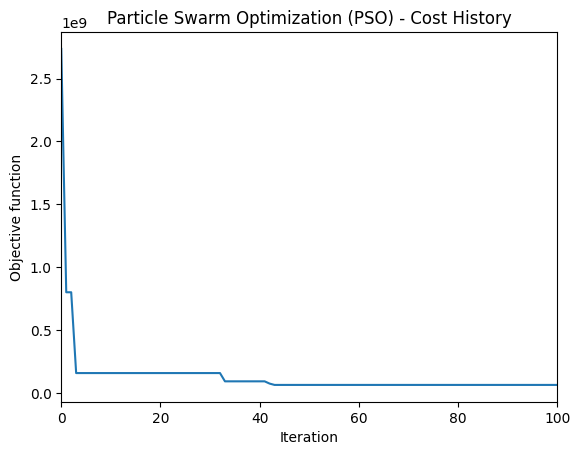

                              
*************************************************************************
Número total de iterações: 100
Número de Particulas: 100
Número de Dimensões: 24
                              
Melhor partícula: 470618017.3628296


In [29]:
# Plotar gráfico de densidade da otimização
plt.figure()
plt.plot(optimizer.cost_history)
plt.xlabel('Iteration')
plt.xlim(0, max_iterations)
plt.ylabel('Objective function')
plt.title('Particle Swarm Optimization (PSO) - Cost History')
plt.show()

print("                              ")
print("*************************************************************************")
print("Número total de iterações:", max_iterations)
print("Número de Particulas:", num_particles)
print("Número de Dimensões:", dimensions)
print("                              ")
print("Melhor partícula:", pbest_cost[0])

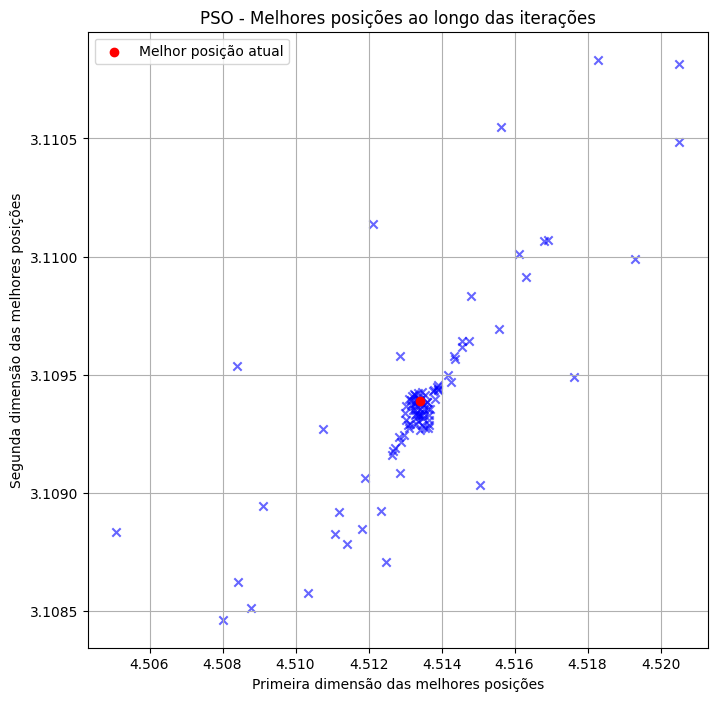

In [30]:
# Plotar o gráfico 3D com todas as melhores posições
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)

# Plotar todas as melhores posições anteriores
for i in range(best_positions.shape[0]):
    ax.scatter(best_positions[i, 0], best_positions[i, 1], marker='x', c='blue', alpha=0.6)

# Plotar a última melhor posição com uma cor diferente para destacá-la
ax.scatter(best_positions[-1, 0], best_positions[-1, 1], c='red', label='Melhor posição atual')

ax.set_title('PSO - Melhores posições ao longo das iterações')
ax.set_xlabel('Primeira dimensão das melhores posições')
ax.set_ylabel('Segunda dimensão das melhores posições')
ax.legend()
plt.grid()
plt.show()